# **$$ Sentiment-Analysis$$**

### Import the dependencies

In [22]:
! pip install nltk


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import numpy as np 
import pandas as pd 
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [24]:
import os
import sys

# Force download using command line
os.system('python -m nltk.downloader -d ~/nltk_data punkt')
os.system('python -m nltk.downloader -d ~/nltk_data stopwords') 
os.system('python -m nltk.downloader -d ~/nltk_data vader_lexicon')

print("NLTK packages downloaded!")

NLTK packages downloaded!


In [26]:
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(f"English stopwords loaded: {len(stop_words)}")
print(f"Sample stopwords: {stop_words}")

English stopwords loaded: 198
Sample stopwords: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 

### Load the data

In [27]:
# load sentiment data
twitter_data = pd.read_csv('../data/raw/tweets.csv', encoding='ISO-8859-1')

### Data Processing

In [28]:
twitter_data.shape

(1599999, 6)

In [29]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [30]:
# Naming the column and reading the dataset again

column_names=['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data = pd.read_csv('../data/raw/tweets.csv', names =column_names, encoding='ISO-8859-1')

In [31]:
twitter_data.shape

(1600000, 6)

In [32]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [55]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [56]:
print(twitter_data.describe())

          target            id
count  1600000.0  1.600000e+06
mean         0.5  1.998818e+09
std          0.5  1.935761e+08
min          0.0  1.467810e+09
25%          0.0  1.956916e+09
50%          0.5  2.002102e+09
75%          1.0  2.177059e+09
max          1.0  2.329206e+09


In [33]:
# Check the missing value
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [34]:
# Check the distribution of target column
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

##### Here we have equal distribution

In [35]:
# Label Maping/ Label encoding
twitter_data.replace({'target': {4:1}}, inplace=True)

In [36]:
twitter_data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

##### 0 --> Negative tweet
##### 1 --> Positive tweet

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

In [45]:
# Function to clean and extract words
def extract_words(text):
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.lower().split()
    
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return words


In [46]:
# Extract all words from tweets
all_words = []
for text in twitter_data['text']:
    if pd.notna(text):  
        all_words.extend(extract_words(str(text)))

# Count word frequencies
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

words, counts = zip(*most_common_words)

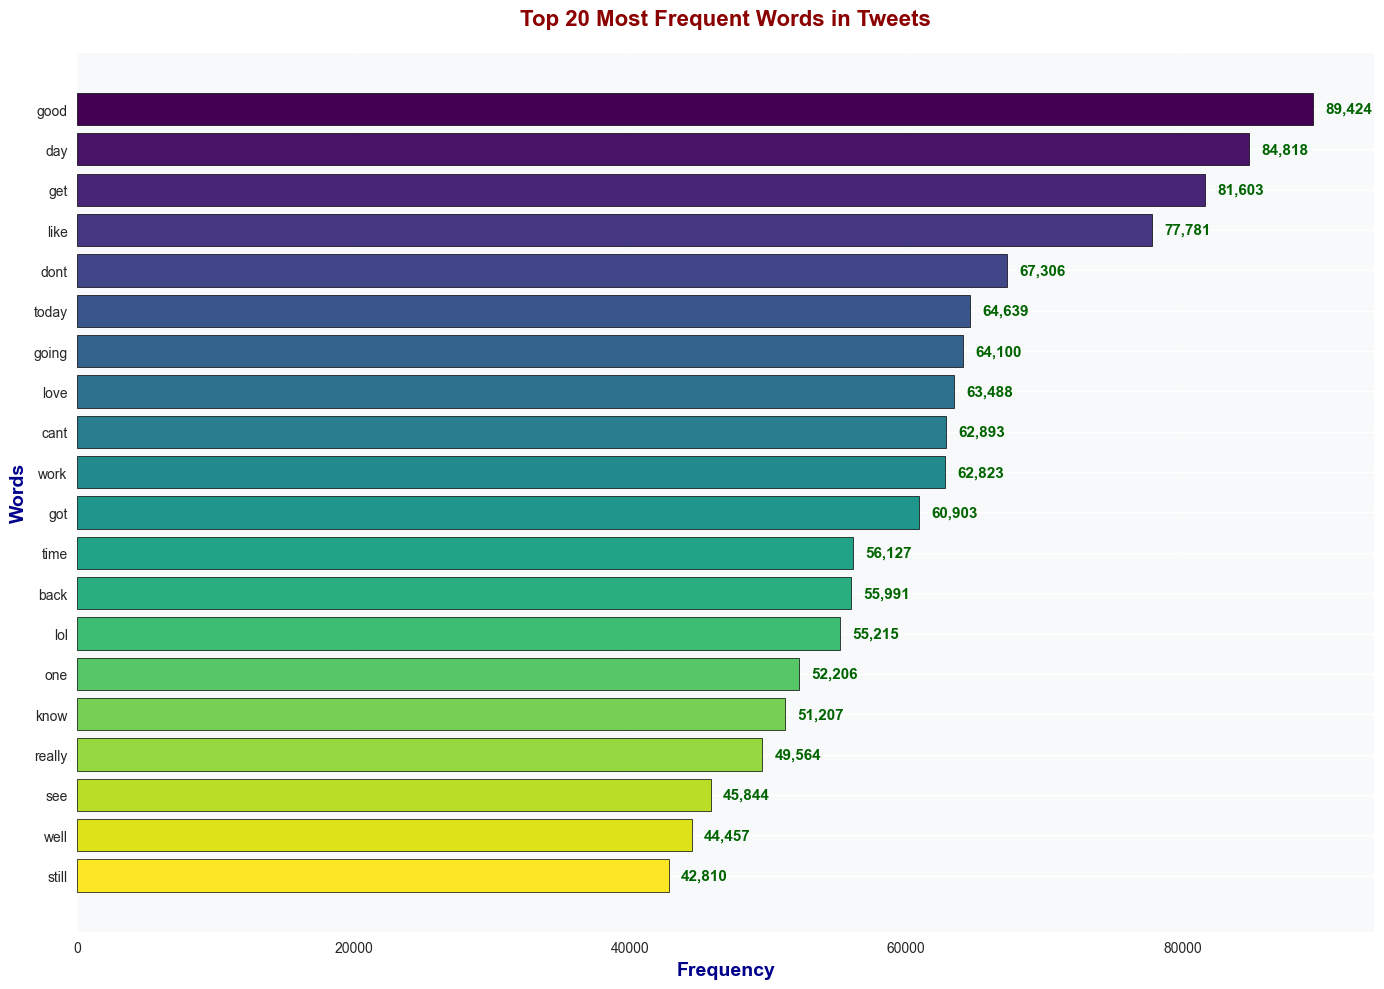

In [47]:
plt.style.use('seaborn-v0_8')  
fig, ax = plt.subplots(figsize=(10, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(words)))
bars = ax.barh(words, counts, color=colors, edgecolor='black', linewidth=0.5)

# Customize the plot
ax.set_xlabel('Frequency', fontsize=14, fontweight='bold', color='darkblue')
ax.set_ylabel('Words', fontsize=14, fontweight='bold', color='darkblue')
ax.set_title('Top 20 Most Frequent Words in Tweets', 
             fontsize=16, fontweight='bold', color='darkred', pad=20)
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    width = bar.get_width()
    ax.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', ha='left', va='center', 
            fontweight='bold', fontsize=11, color='darkgreen')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.set_facecolor('#f8f9fa')

# Adjust layout
plt.tight_layout()
plt.show()

### WordCloud Analysis

In [48]:
! pip install wordcloud


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


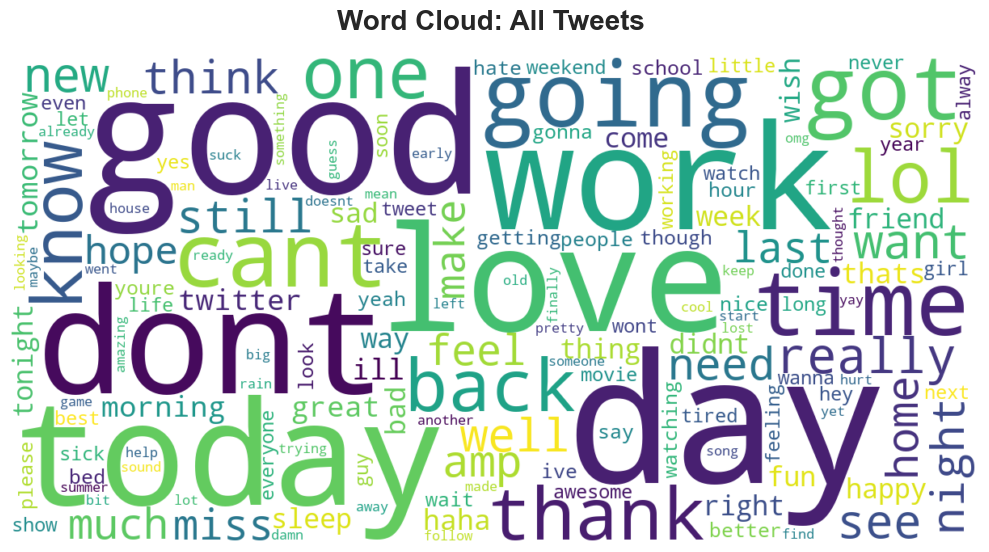

In [ ]:
from wordcloud import WordCloud

wordcloud_text = ' '.join(all_words)
plt.figure(figsize=(8, 5))
wordcloud = WordCloud(width=1200, height=600, 
                     background_color='white',
                     max_words=150,
                     colormap='viridis',
                     relative_scaling=0.5,
                     random_state=42,
                     collocations=False).generate(wordcloud_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud: All Tweets ', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Negative WordCloud

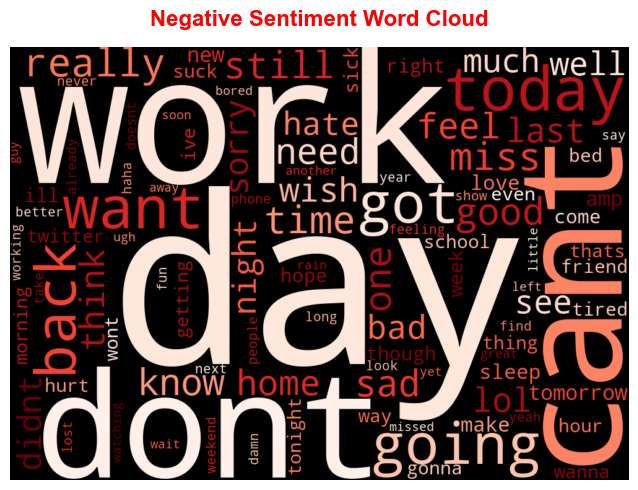

In [ ]:
plt.figure(figsize=(8, 5))

# Get negative words
negative_tweets = twitter_data[twitter_data['target'] == 0]['text']
negative_words = []
for text in negative_tweets:
    if pd.notna(text):
        negative_words.extend(extract_words(str(text)))

negative_text = ' '.join(negative_words)

wordcloud_negative = WordCloud(width=1000, height=700, 
                              background_color='black',
                              max_words=100,
                              colormap='Reds',
                              relative_scaling=0.5,
                              random_state=42,
                              collocations=False).generate(negative_text)

plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud', 
          fontsize=16, fontweight='bold', color='black', pad=15)
plt.tight_layout()
plt.show()


### Positive WordCLoud

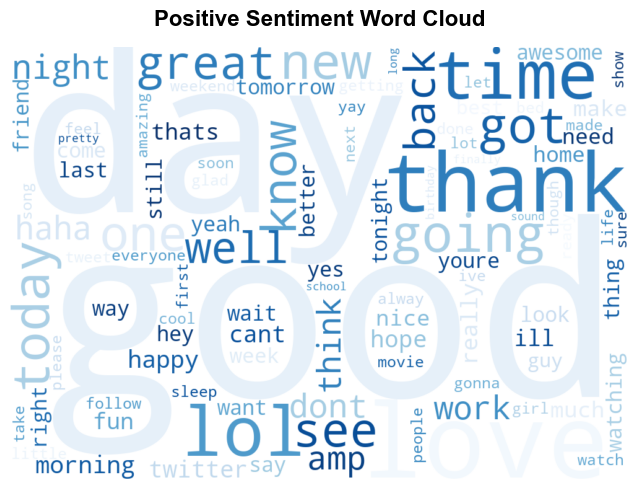

In [54]:
# Individual Positive Word Cloud  
plt.figure(figsize=(8, 5))

# Get positive words
positive_tweets = twitter_data[twitter_data['target'] == 1]['text']
positive_words = []
for text in positive_tweets:
    if pd.notna(text):
        positive_words.extend(extract_words(str(text)))

positive_text = ' '.join(positive_words)

wordcloud_positive = WordCloud(width=1000, height=700, 
                              background_color='white',
                              max_words=100,
                              colormap='Blues',
                              relative_scaling=0.5,
                              random_state=42,
                              collocations=False).generate(positive_text)

plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud', 
          fontsize=16, fontweight='bold', color='black', pad=15)
plt.tight_layout()
plt.show()

---